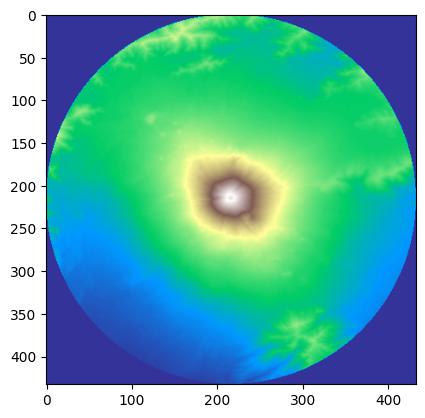

Each pixel of the image corresponds to 0.09240117776629594 km


In [1]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
from geopy.distance import geodesic

file = rasterio.open('output_SRTMGL3.tif')
dataset = file.read()
dataset_m = dataset.squeeze()
dataset_km = dataset_m/1000
plt.imsave('dataset_m.jpg', dataset_m, cmap='terrain')

# Coordinates from the bounding box
xmin, ymin = 138.46873124918292, 35.122132336867196
xmax, ymax = 139.00075354383853, 35.56353843656372

# Calculating the distance between the min and max coordinates for width and height
width_km = geodesic((ymin, xmin), (ymin, xmax)).kilometers
height_km = geodesic((ymin, xmin), (ymax, xmin)).kilometers

# Center of Mount Fuji
center_fuji = [242, 315]
radius_km = 20

# We will take the height as accurate since it does not suffer changes in the Mercator projection
mat_element_km = height_km / dataset_km.shape[0]

# Calculate which point lie outside of the circle with center in center_fuji and radius 25km, and set them to 0
R = radius_km / mat_element_km
for i in range(dataset_km.shape[0]):
    for j in range(dataset_km.shape[1]):
        if np.sqrt((i - center_fuji[0])**2 + (j - center_fuji[1])**2) >= R:
            dataset_km[i, j] = 0


# Delete rows or columns whose values are all 0
dataset_km = dataset_km[~np.all(dataset_km == 0, axis=1)]
dataset_km = dataset_km[:, ~np.all(dataset_km == 0, axis=0)]

show(dataset_km, cmap='terrain')
print("Each pixel of the image corresponds to {} km".format(mat_element_km))


Text(0.5, 0.92, '3D Plot of Height Matrix')

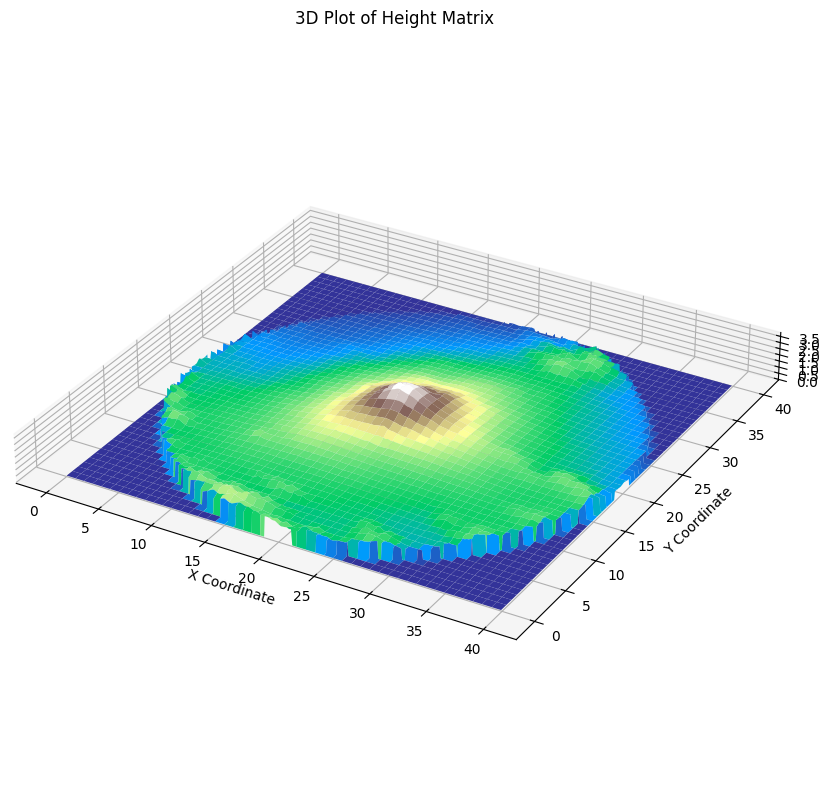

In [2]:
# Creating X, Y coordinates grid
x = np.arange(dataset_km.shape[1]*mat_element_km, step=mat_element_km)
y = np.arange(dataset_km.shape[0]*mat_element_km, step=mat_element_km)
X, Y = np.meshgrid(x, y)

# Plotting the 3D surface plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, dataset_km, cmap='terrain')


# Setting axis sizes to be equal to each other
ax.set_box_aspect([1,1,0.1])

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Height')
ax.set_title('3D Plot of Height Matrix')


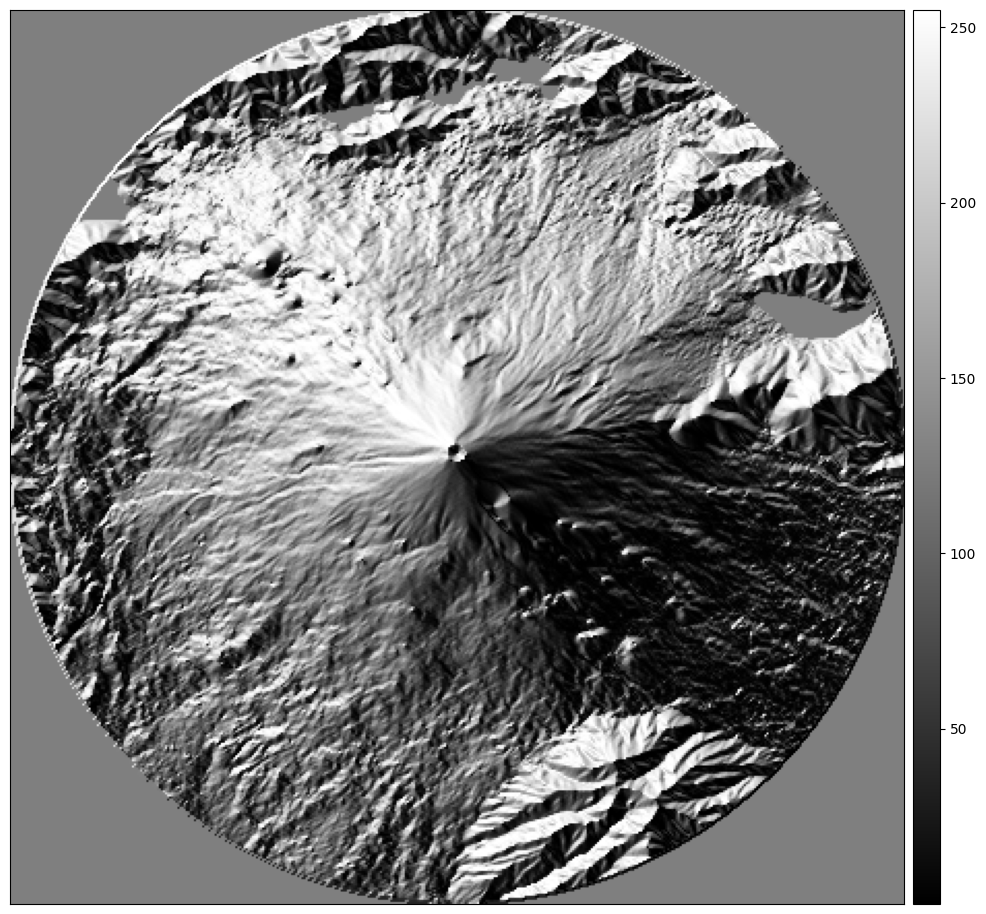

The total volume of Mount Fuji is 1284.4607860974947 km^3


In [3]:
import earthpy.spatial as es
import earthpy.plot as ep

hillshade = es.hillshade(dataset_km*1000, azimuth=315, altitude=0)

ep.plot_bands(hillshade, cmap='gray')
plt.show()

total_volume_truth = np.sum(dataset_km*(mat_element_km**2))
print("The total volume of Mount Fuji is {} km^3".format(total_volume_truth))

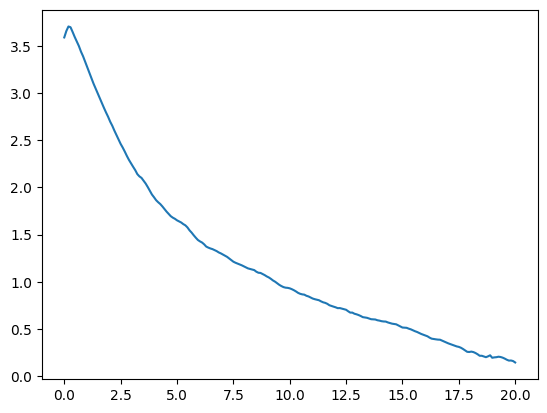

In [6]:
def calc_alphas(divisions):
    """Calculates the angles for the divisions"""
    alphas = np.zeros(divisions)
    for i in range(divisions):
        alphas[i] = i*2*np.pi/divisions
    return alphas

def calc_height_profile(dataset, alpha):
    """Calculates de array corresponding to the height profile given the angle alpha"""
    array_heights = np.zeros(int(np.ceil(R)))
    for i in range(len(array_heights)):
        x = i*np.cos(alpha) + dataset_km.shape[1]/2
        y = i*np.sin(alpha) + dataset_km.shape[0]/2
        array_heights[i] = dataset_km[int(x), int(y)]
    return array_heights

divisions = 1
matrix_profiles = np.zeros((divisions, int(np.ceil(R))))
alphas = calc_alphas(divisions)
for i in range(divisions):
    matrix_profiles[i] = calc_height_profile(dataset_km, alphas[i])

# Matrix profiles contains the height profiles for each division as individual rows
for profile in matrix_profiles:
    plt.plot(np.linspace(0, 20, len(matrix_profiles[0])),profile)


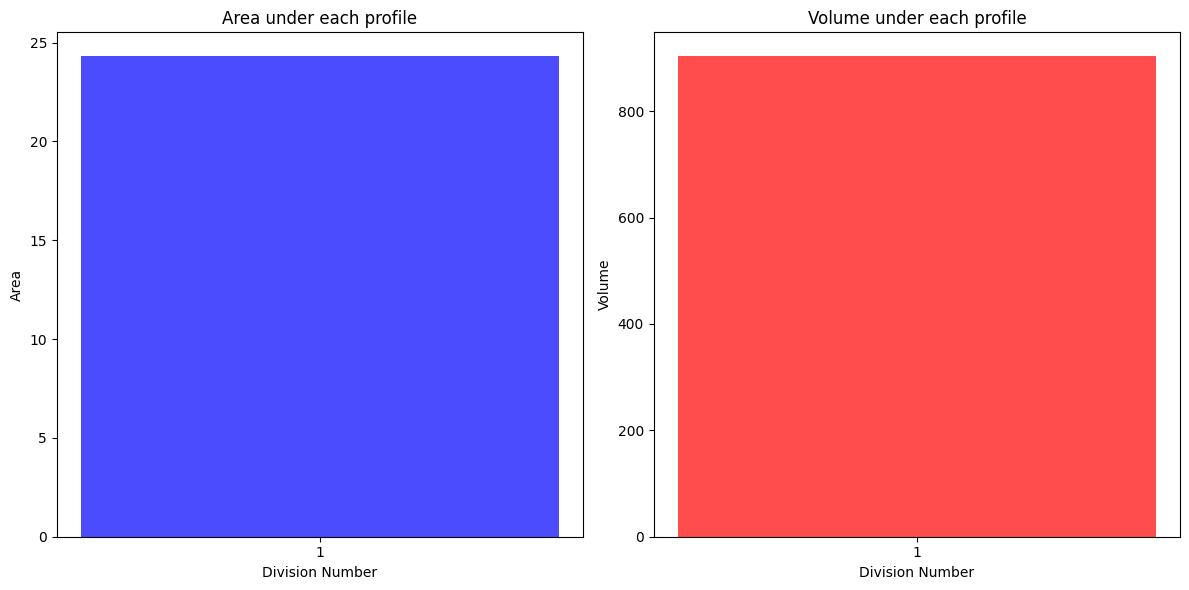

The area under each profile is: [24.30437419]
The total volume of Mount Fuji is 1284.4607860974947 km^3
The total predicted volume of Mount Fuji is 903.1270312652393 km^3
The absolute error is 381.3337548322554 km^3


In [7]:
# Area under each profile
area_profiles = np.zeros(divisions)
for i in range(divisions):
    area_profiles[i] = np.sum(matrix_profiles[i]*mat_element_km)

volume_profiles = np.zeros(divisions)
for i in range(divisions):
    volume_per_division = np.zeros(len(matrix_profiles[i]))
    for j in range(len(matrix_profiles[i])):
        volume_per_height = np.pi/(divisions) * matrix_profiles[i][j] * (((j+1)*mat_element_km)**2 - (j*mat_element_km)**2)
        volume_per_division[j] = volume_per_height
    volume_profiles[i] = np.sum(volume_per_division)
    
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for area
ax[0].bar(np.arange(divisions), area_profiles, color='b', alpha=0.7)
ax[0].set_xlabel('Division Number')
ax[0].set_ylabel('Area')
ax[0].set_title('Area under each profile')
ax[0].set_xticks(np.arange(divisions))
ax[0].set_xticklabels(np.arange(divisions) + 1)

# Plot for volume
ax[1].bar(np.arange(divisions), volume_profiles, color='r', alpha=0.7)
ax[1].set_xlabel('Division Number')
ax[1].set_ylabel('Volume')
ax[1].set_title('Volume under each profile')
ax[1].set_xticks(np.arange(divisions))
ax[1].set_xticklabels(np.arange(divisions) + 1)

plt.tight_layout()
plt.show()

# Outputting the area and volume for each profile
print("The area under each profile is: {}".format(area_profiles))

total_volume_truth = np.sum(dataset_km*(mat_element_km**2))
print("The total volume of Mount Fuji is {} km^3".format(total_volume_truth))
total_volume_pred = np.sum(volume_profiles)
print("The total predicted volume of Mount Fuji is {} km^3".format(total_volume_pred))
print("The absolute error is {} km^3".format(np.abs(total_volume_truth - total_volume_pred)))

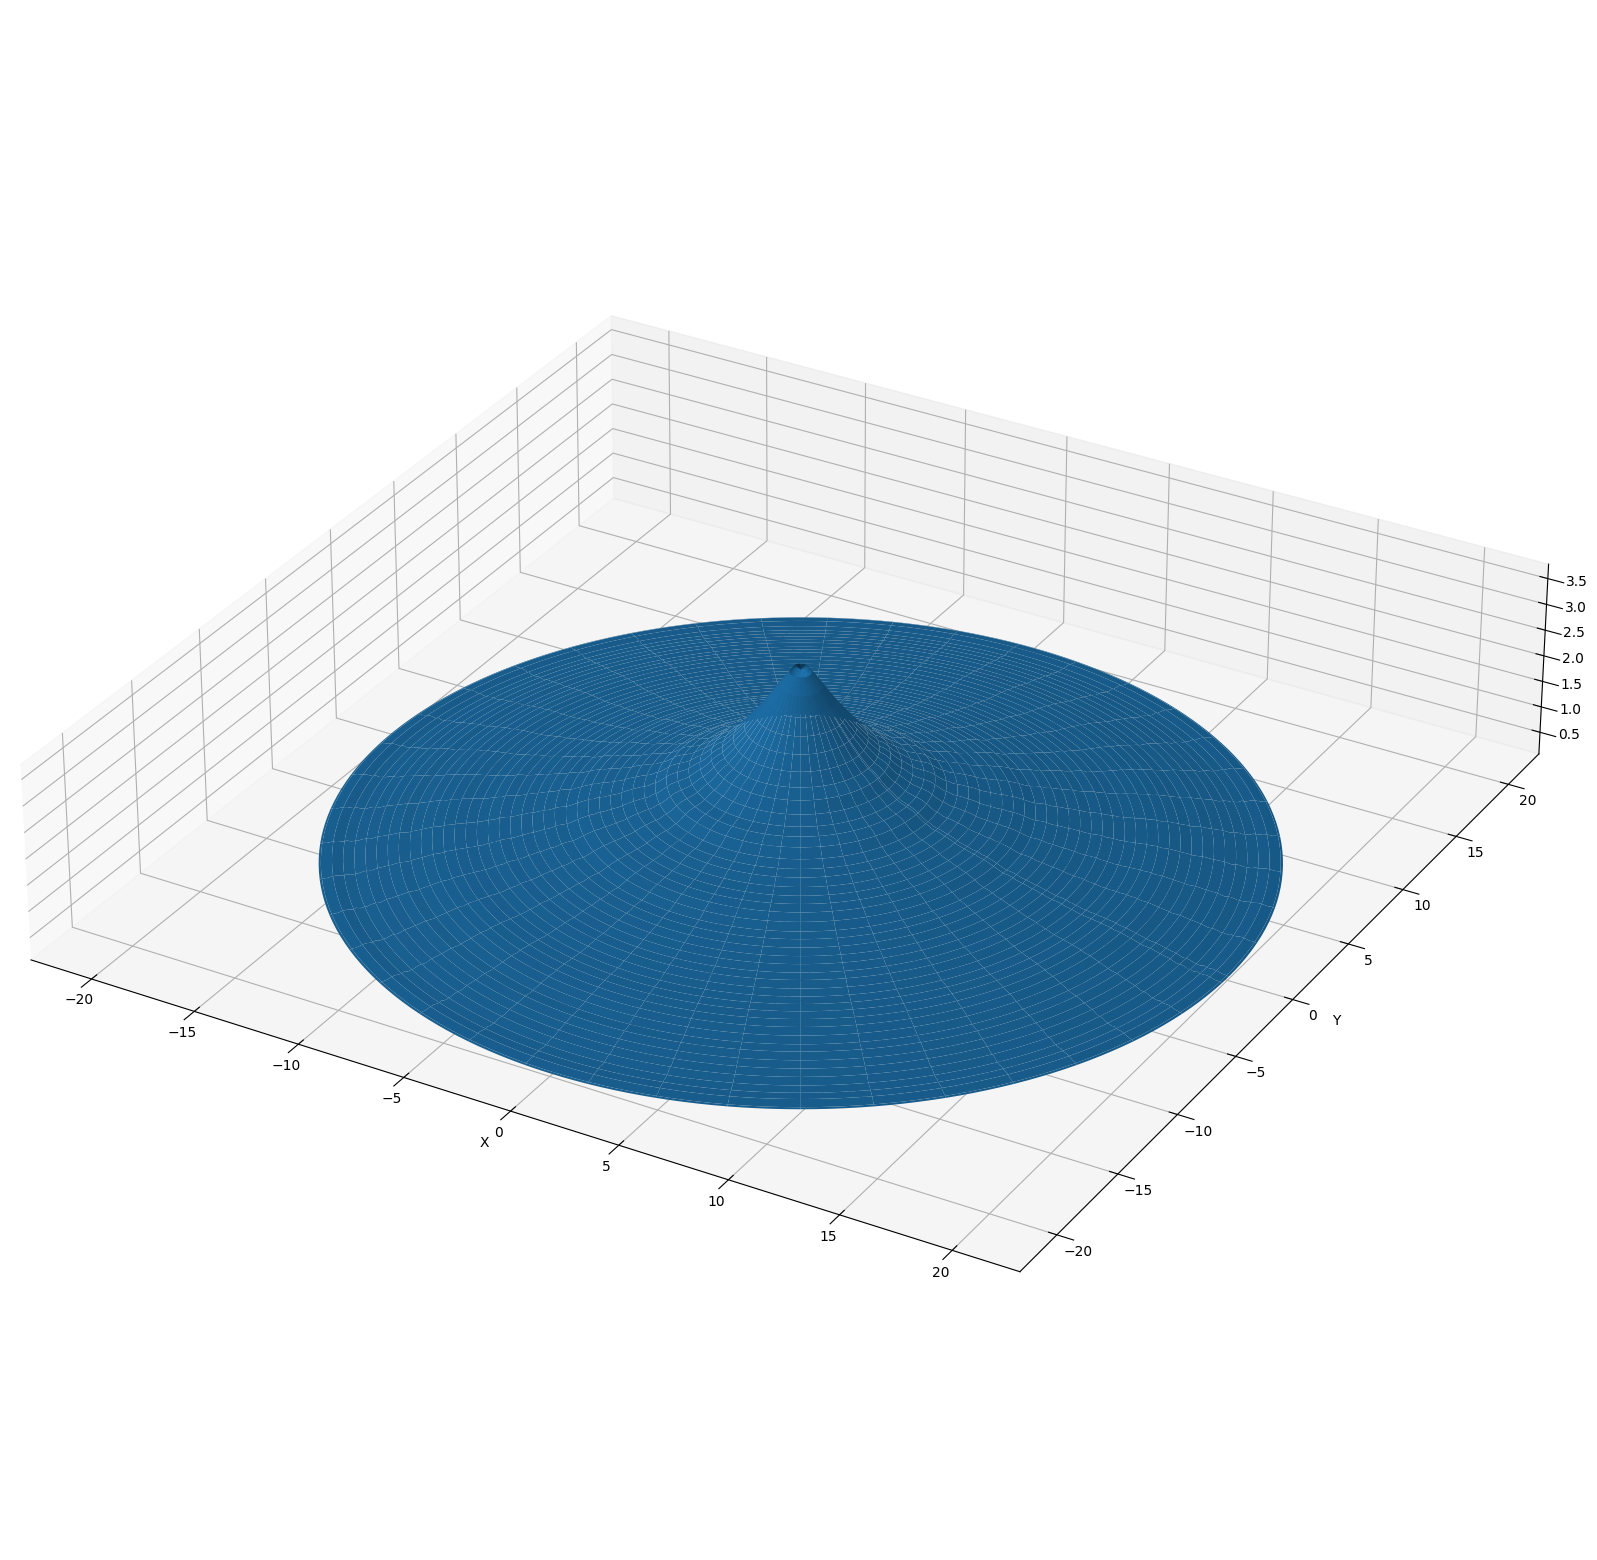

In [8]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Define the range for u
u = np.linspace(0, int(np.ceil(R)), int(np.ceil(R)))

# Angular range for each profile
angle_per_profile = 2 * np.pi / divisions

# Loop through each profile and create a surface
for i, profile in enumerate(matrix_profiles):
    start_angle = i * angle_per_profile
    end_angle = (i + 1) * angle_per_profile
    v = np.linspace(start_angle, end_angle, int(np.ceil(R)))  # Angular range for this profile
    U, V = np.meshgrid(u, v)
    X = U*np.cos(V)*mat_element_km
    Y = U*np.sin(V)*mat_element_km
    Z = np.broadcast_to(profile, X.shape)

    # Plot the surface for this section
    ax.plot_surface(X, Y, Z, edgecolor='none', alpha=1)
    # Make surface opacity 1 and hide mesh lines


# Make it so that you can pan around the figure with your mouse
# ax.view_init(azim=0, elev=90)

# Label the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# make axes the same size
ax.set_box_aspect([1,1,0.2])

plt.show()


